



|Dataset Used|T_stat|P_stat|Cohen's d|Confidence Interval|
|---|---|---|---|---|
|Dataset|   |   |   |   |
|Z-score|   |   |   |   |
|IRQ|   |   |   |   |

# TVOC Measurement Analysis
## Using TVOC Maximum Dataset

In [79]:
# @hidden_cell
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.metrics.pairwise import cosine_similarity
import scipy.stats as stats
import seaborn as sns
from sklearn.ensemble import IsolationForest

In [27]:
df = pd.read_excel('TVOC_max_KK.xlsx')
df.head()

,leed_Id,project_name,organization,partner,direct_sensor_data,start_time,end_time,reading,Unnamed: 8,Unnamed: 9
0,1000097465,Burberry Hanam Starfield,Burberry Korea Limited,Abacus,No,2018-08-28,2018-08-29,100.00,NaN,"If Max TVOC calculated is Yes, that means the ..."
1,8000016883,Renteknik Group Inc,Renteknik group Inc.,Abacus,Yes,2022-05-03,2022-05-04,0.00,NaN,"If Max TVOC calculated is No, that means the p..."
2,8000016883,Renteknik Group Inc,Renteknik group Inc.,Abacus,Yes,2022-05-04,2022-05-05,0.00,NaN,NaN
3,8000016883,Renteknik Group Inc,Renteknik group Inc.,Abacus,Yes,2022-05-05,2022-05-06,0.00,NaN,NaN
4,8000016883,Renteknik Group Inc,Renteknik group Inc.,Abacus,Yes,2022-05-06,2022-05-07,29.41,NaN,NaN


In [28]:
len(df)

206583

In [29]:
len(df['leed_Id'].unique())

688

In [30]:
df = df.drop(columns=['Unnamed: 8', 'Unnamed: 9'])

### Data overview
 - maximum reading is 60,000 ug/m3
 - no negative readings

In [31]:
print(df.describe())

            leed_Id        reading
count  2.065830e+05  206583.000000
mean   1.189386e+09     502.370697
std    1.157099e+09    1656.991283
min    1.000156e+07       0.000000
25%    1.000051e+09     150.155882
50%    1.000059e+09     280.000000
75%    1.000100e+09     509.640000
max    8.000024e+09   60000.000000


### There are a few partners with similar names or collaborations

In [32]:
len(df['partner'].unique())
#deleting test APP
df = df[df['partner'] != 'test APP']

In [70]:
(df['partner_group'].unique())

array(['Abacus', 'Arbnco', 'BEE', 'Bractlet', 'Commutifi', 'EPL OAUTH2',
       'FGB', 'Idun', 'QLEAR', 'SLB', 'Tishman Speyer', 'Tridium',
       'WatchWire', 'Wattics'], dtype=object)

In [67]:
df['partner_group'] = df['partner'].str.lower().str.split('/').str[0].str.strip()

In [68]:
# Mapping representative names for each group
partner_mapping  = {
    'abacus': 'Abacus',
    'Abacus': 'Abacus',
    'arbnwell': 'Arbnco',
    'arbnwell data push integration': 'Arbnco',
    'bee': 'BEE',
    'bractlet intelligence platform - live': 'Bractlet',
    'commutifi': 'Commutifi',
    'epl oauth2': 'EPL OAUTH2',
    'fgb': 'FGB',
    'idun-local-certify-api': 'Idun',
    'idun-prod-certify-api' : 'Idun',
    'qlear': 'QLEAR',
    'slb': 'SLB',
    'slb_arc_datalake_prod': 'SLB',
    'tishman speyer live': 'Tishman Speyer',
    'usgbc tridiuum': 'Tridium',
    'watchwire': 'WatchWire',
    'wattics energy analytics': 'Wattics',
    'Wattics Energy Analytics':'Wattics'
}

df['partner_group'] = df['partner_group'].map(partner_mapping)

### Arbnco is grouped by the following:
 - arbnwell/Arbnco
 - arbnwell
 - arbnwell data push integration
 - arbnwell data push integration/Arbnco
 
BEE is grouped by:
- BEE
- BEE/Qlear

Bractlet is from:
- Bractlet Intelligence Platform - LIVE

Idun is grouped by the following:
- idun-local-certify-api
- idun-prod-certify-api

QLEAR is grouped by:
- QLEAR/Qlear
- QLEAR

SLB is grouped by the following:
- SLB
- SLB_Arc_Datalake_Prod

Wattics is grouped by the following:
- Wattics Energy Analytics
- Wattics Energy Analytics/Qlear

Others:
Tishman Speyer is Tishman Speyer Live, Tridium is USGBC Tridiuum, WatchWire is WatchWire, Abacus is Abacus, Commutifi is Commutifi, EPL OAUTH2 is EPL OAUTH2, FGB is FGB

### Histogram of Arbnco readings

In [71]:
arbnco = df[df['partner_group'] == 'Arbnco'].copy()
abacus = df[df['partner_group'] == 'Abacus'].copy()
bee = df[df['partner_group'] == 'BEE'].copy()
bractlet = df[df['partner_group'] == 'Bractlet'].copy()
commutifi = df[df['partner_group'] == 'Commutifi'].copy()
epl = df[df['partner_group'] == 'EPL OAUTH2'].copy()
fgb = df[df['partner_group'] == 'FGB'].copy()
idun = df[df['partner_group'] == 'Idun'].copy()
qlear = df[df['partner_group'] == 'QLEAR'].copy()
slb = df[df['partner_group'] == 'SLB'].copy()
tishman = df[df['partner_group'] == 'Tishman Speyer'].copy()
tridium = df[df['partner_group'] == 'Tridium'].copy()
watchwire = df[df['partner_group'] == 'WatchWire'].copy()
wattics = df[df['partner_group'] == 'Wattics'].copy()

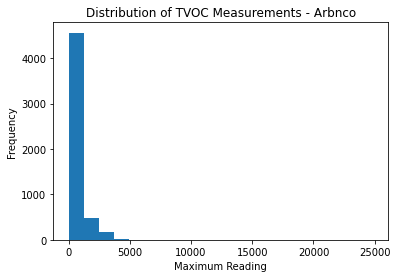

count     5260.000000
mean       647.971650
std        957.826949
min          0.000000
25%        149.232636
50%        423.958727
75%        736.239222
max      24853.700000
Name: reading, dtype: float64


In [74]:
# histogram of TVOC measurements for arbnco
plt.hist(arbnco['reading'], bins=20)
plt.xlabel('Maximum Reading')
plt.ylabel('Frequency')
plt.title('Distribution of TVOC Measurements - Arbnco')
plt.show()

# Summary of statistics for arbnco
arbnco_stats = arbnco['reading'].describe()
print(arbnco_stats)

### Preliminary Results
T-statistic:
The t-statistic measures the difference between the means of Arbnco's TVOC readings and the rest of the partners, relative to the variability within the groups. It is calculated as the difference in means divided by the standard error of the difference.
In this case, **the t-statistic value of 10.89 indicates a large difference between Arbnco's TVOC measurements and the rest of the partners.**

P-value:
The p-value represents the probability of observing a t-statistic as extreme as the one obtained in the sample data, assuming the null hypothesis is true. Here, the null hypothesis states that there is no difference between Arbnco's TVOC measurements and the rest of the partners.
The p-value you provided, 2.34e-27, is an extremely small value. This suggests strong evidence **against** the null hypothesis and indicates that the **observed difference between Arbnco and the other partners is statistically significant.**

With a very small p-value (e.g., less than 0.05), we can conclude that Arbnco's TVOC measurements are significantly different from the rest of the partners. The t-statistic value of 10.89 further supports this conclusion, indicating a substantial difference in TVOC measurements between Arbnco and the other partners. The results suggest that Arbnco's TVOC measurements are statistically significantly higher than the TVOC measurements of the other partners.

In [14]:
# Filter data for Arbnco and its aliases
arbnco_data = df[df['partner'].isin(arbnco_aliases)]

# Filter data for partners other than Arbnco
other_partners_data = df[~df['partner'].isin(arbnco_aliases)]

# Perform an independent t-test
t_stat, p_value = stats.ttest_ind(arbnco_data['reading'], other_partners_data['reading'], equal_var=False)

if p_value < 0.05:
    print("Arbnco's TVOC measurements are statistically significantly higher than the rest of the partners.")
else:
    print("Arbnco's TVOC measurements are not statistically significantly higher than the rest of the partners.")

# Print mean values
print("Mean TVOC for Arbnco:", arbnco_data['reading'].mean())
print("Mean TVOC for other partners:", other_partners_data['reading'].mean())

# Print t-statistic and p-value
print("t-statistic:", t_stat)
print("p-value:", p_value)

Arbnco's TVOC measurements are statistically significantly higher than the rest of the partners.
Mean TVOC for Arbnco: 647.9716502615969
Mean TVOC for other partners: 498.56655587897023
t-statistic: 10.88811614166103
p-value: 2.3353703287230704e-27


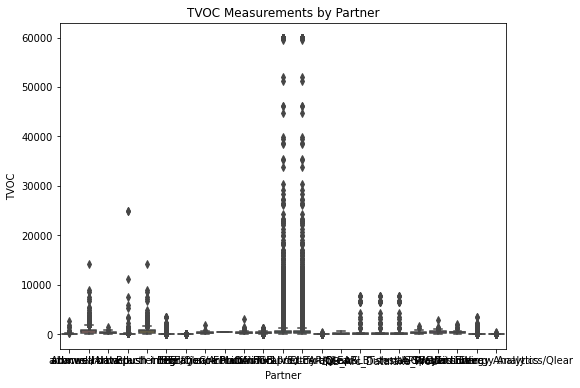

In [15]:
# Box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['partner'], y=df['reading'])
plt.xlabel('Partner')
plt.ylabel('TVOC')
plt.title('TVOC Measurements by Partner')
plt.show()

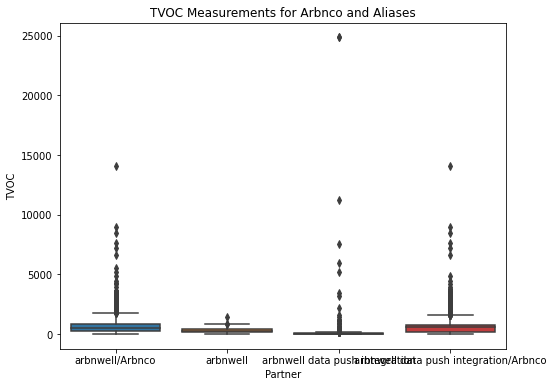

In [16]:
import seaborn as sns

# Filter data for Arbnco and its aliases
arbnco_data = df[df['partner'].isin(arbnco_aliases)]

# Generate a box plot for Arbnco and aliases only
plt.figure(figsize=(8, 6))
sns.boxplot(x=arbnco_data['partner'], y=arbnco_data['reading'])
plt.xlabel('Partner')
plt.ylabel('TVOC')
plt.title('TVOC Measurements for Arbnco and Aliases')
plt.show()

In [17]:
max_reading = df['reading'].max()
partner_with_max_reading = df.loc[df['reading'].idxmax(), 'partner']

print("The maximum reading value is:", max_reading)
print("It corresponds to the partner:", partner_with_max_reading)


The maximum reading value is: 60000.0
It corresponds to the partner: idun-local-certify-api


### Using various methods to determine outliers, we first used the z-score outliers.

In [54]:
import numpy as np
# Method 1: Z-Score
z_scores = stats.zscore(df['reading'])
z_score_threshold = 3
z_score_outliers = df['reading'][np.abs(z_scores) > z_score_threshold]

# Method 2: IQR
Q1 = df['reading'].quantile(0.25)
Q3 = df['reading'].quantile(0.75)
IQR = Q3 - Q1
iqr_threshold = 1.5
iqr_outliers = df['reading'][(df['reading'] < Q1 - iqr_threshold * IQR) | (df['reading'] > Q3 + iqr_threshold * IQR)]

# Method 3: Isolation Forest
isolation_forest = IsolationForest(contamination='auto')
isolation_forest.fit(df['reading'].values.reshape(-1, 1))
isolation_outliers = df['reading'][isolation_forest.predict(df['reading'].values.reshape(-1, 1)) == -1]

# List of detected outliers
print("Z-Score Outliers:")
print(z_score_outliers.head())
print("\nIQR Outliers:")
print(iqr_outliers.head())
print("\nIsolation Forest Outliers:")
print(isolation_outliers.head())

len(z_score_outliers)
len(iqr_outliers)

Z-Score Outliers:
934     7172.494978
995     7592.645341
1011    8490.985422
1027    8971.403489
1029    6657.982034
Name: reading, dtype: float64

IQR Outliers:
7      1451.52
8      1513.03
9      1877.11
10     2656.94
264    1393.67
Name: reading, dtype: float64

Isolation Forest Outliers:
4       29.41
7     1451.52
8     1513.03
9     1877.11
10    2656.94
Name: reading, dtype: float64


19752

## Describe the outliers from the dataset
Why are they outliers? 

### I'm picking the z_score method for now as it removes the least number of outliers. Isolation forest method is probably a no-go anyway. 

In [41]:
# Calculate z-scores
z_scores = stats.zscore(df['reading'])
z_score_threshold = 3
df_zscore = df[np.abs(z_scores) <= z_score_threshold]
arbnco_data = df_zscore[df_zscore['partner'].isin(arbnco_aliases)]
other_partners_data = df_zscore[~df_zscore['partner'].isin(arbnco_aliases)]
t_stat, p_value = stats.ttest_ind(arbnco_data['reading'], other_partners_data['reading'], equal_var=False)

if p_value < 0.05:
    print("Arbnco's TVOC measurements (after removing outliers) are statistically significantly higher than the rest of the partners.")
else:
    print("Arbnco's TVOC measurements (after removing outliers) are not statistically significantly higher than the rest of the partners.")

print("Mean TVOC for Arbnco:", arbnco_data['reading'].mean())
print("Mean TVOC for other partners:", other_partners_data['reading'].mean())

print("t-statistic:", t_stat)
print("p-value:", p_value)

Arbnco's TVOC measurements (after removing outliers) are statistically significantly higher than the rest of the partners.
Mean TVOC for Arbnco: 614.7350278752793
Mean TVOC for other partners: 423.5129519542787
t-statistic: 19.665053866094624
p-value: 3.301827077580284e-83


### Even after removing the outliers, the mean TVOC for Arbnco vs other partners is still statistically significantly higher.

Effect Size (Cohen's d):
This quantifies the magnitude or strength of the difference between Arbnco's TVOC measurements and the rest of the partners. Cohen's d is calculated by dividing the difference in means between the two groups by the pooled standard deviation. It provides a standardized measure of the effect, allowing for comparisons across different studies or variables.
Interpreting Cohen's d:
A small effect size (d ≈ 0.2) suggests a relatively small difference between the groups of partners.
A medium effect size (d ≈ 0.5) indicates a moderate difference.
A large effect size (d ≈ 0.8 or higher) signifies a substantial difference.
For example, if Cohen's d is calculated as 0.5, it suggests that Arbnco's TVOC measurements, on average, are half a standard deviation higher than the rest of the partners.

In [42]:
from scipy import stats

# Calculate effect size (Cohen's d)
mean_diff = arbnco_data['reading'].mean() - other_partners_data['reading'].mean()
pooled_std = np.sqrt((arbnco_data['reading'].std()**2 + other_partners_data['reading'].std()**2) / 2)
effect_size = mean_diff / pooled_std

print("Effect size (Cohen's d):", effect_size)


Effect size (Cohen's d): 0.30832576971509157


The effect size is 0.3 which is in between small and medium effect size. There could be anywhere between small and moderate difference

### Confidence Intervals
Confidence intervals provide a range of plausible values for the population parameter (in this case, the mean difference between Arbnco and the other partners' TVOC measurements). A 95% confidence interval, as used in the example, means that if we were to repeat the study multiple times and calculate confidence intervals, we would expect the true population mean difference to fall within the computed interval in approximately 95% of the cases.

If the confidence interval does not include zero, it suggests that the mean difference is statistically significant at the chosen significance level (e.g., 0.05). This indicates that there is evidence of a significant difference between Arbnco and the other partners.
If the confidence interval includes zero, it suggests that the mean difference is not statistically significant, and we cannot conclude that there is a significant difference between Arbnco and the other partners.
For example, a 95% confidence interval of (0.1, 0.3) would indicate that we can be 95% confident that the true mean difference in TVOC measurements between Arbnco and the other partners falls within the range of 0.1 to 0.3 units.

In [43]:
# Calculate confidence intervals
mean_diff = arbnco_data['reading'].mean() - other_partners_data['reading'].mean()
std_diff = np.sqrt((arbnco_data['reading'].std()**2 / len(arbnco_data)) + (other_partners_data['reading'].std()**2 / len(other_partners_data)))
confidence_interval = stats.t.interval(0.95, len(df_filtered)-1, loc=mean_diff, scale=std_diff)

print("Confidence Interval (95%):", confidence_interval)


Confidence Interval (95%): (172.16336438565867, 210.28078745634258)


So this means that the a 95% confidence interval of (172.16336438565867, 210.28078745634258) has a lower and upper bound of 172 and 211 difference in measurements higher than the mean.

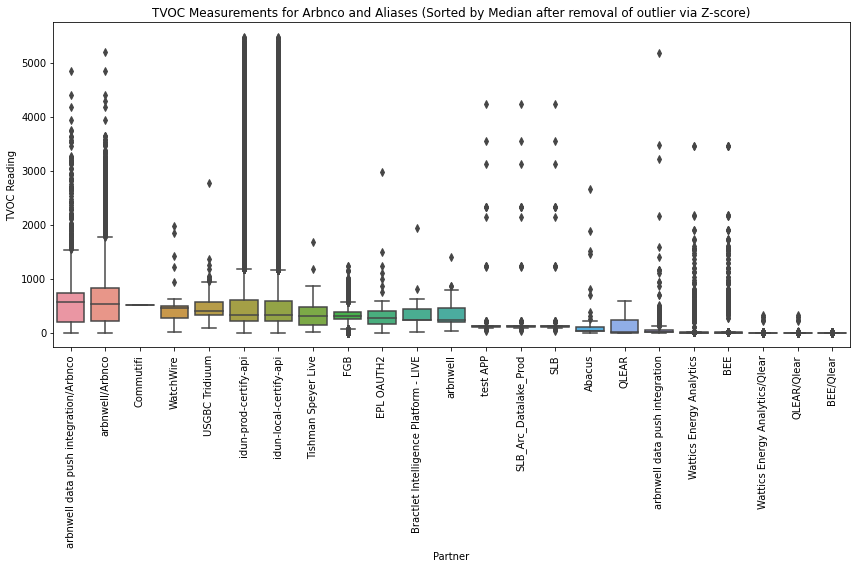

In [52]:
median_readings = df_zscore.groupby('partner')['reading'].median().sort_values(ascending=False)
partner_order = median_readings.index

plt.figure(figsize=(12, 8))
sns.boxplot(x='partner', y='reading', data=df_zscore, order=partner_order)
plt.xlabel('Partner')
plt.ylabel('TVOC Reading')
plt.title('TVOC Measurements for Arbnco and Aliases (Sorted by Median after removal of outlier via Z-score)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


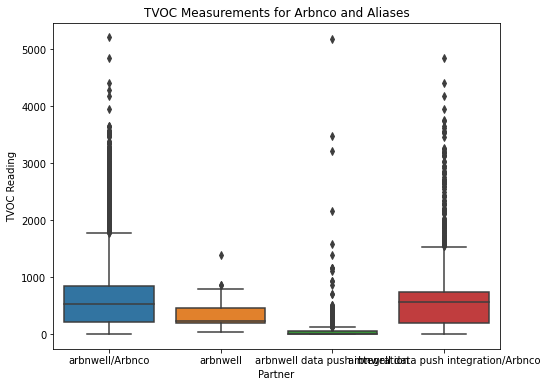

In [44]:
# Create boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='partner', y='reading', data=df_zscore[df_zscore['partner'].isin(arbnco_aliases)])
plt.xlabel('Partner')
plt.ylabel('TVOC Reading')
plt.title('TVOC Measurements for Arbnco and Aliases')
plt.show()


### Using IQR outlier method
I'm going to do the same analysis but using the IQR method instead of z_score

In [46]:
Q1 = df['reading'].quantile(0.25)
Q3 = df['reading'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_iqr = df[(df['reading'] >= lower_bound) & (df['reading'] <= upper_bound)]

arbnco_data = df_iqr[df_iqr['partner'].isin(arbnco_aliases)]
other_partners_data = df_iqr[~df_iqr['partner'].isin(arbnco_aliases)]

t_stat, p_value = stats.ttest_ind(arbnco_data['reading'], other_partners_data['reading'], equal_var=False)

print("Mean TVOC for Arbnco:", arbnco_data['reading'].mean())
print("Mean TVOC for other partners:", other_partners_data['reading'].mean())

print("t-statistic:", t_stat)
print("p-value:", p_value)

Mean TVOC for Arbnco: 363.26666909817766
Mean TVOC for other partners: 294.381099015809
t-statistic: 16.124444533843192
p-value: 6.251629938121122e-57


Cohen's d: Effect size has decreased a little bit from the z_score method at ~0.26


In [47]:
# Calculate effect size (Cohen's d)
mean_diff = arbnco_data['reading'].mean() - other_partners_data['reading'].mean()
pooled_std = np.sqrt((arbnco_data['reading'].std()**2 + other_partners_data['reading'].std()**2) / 2)
effect_size = mean_diff / pooled_std

print("Effect size (Cohen's d):", effect_size)


Effect size (Cohen's d): 0.2631094174070508


Confidence Interval

In [48]:
# Calculate confidence intervals
mean_diff = arbnco_data['reading'].mean() - other_partners_data['reading'].mean()
std_diff = np.sqrt((arbnco_data['reading'].std()**2 / len(arbnco_data)) + (other_partners_data['reading'].std()**2 / len(other_partners_data)))
confidence_interval = stats.t.interval(0.95, len(df_filtered)-1, loc=mean_diff, scale=std_diff)

print("Confidence Interval (95%):", confidence_interval)

Confidence Interval (95%): (60.512318450813936, 77.25882171392335)


So this means that the a 95% confidence interval of (60.512318450813936, 77.25882171392335) has a lower and upper bound of 60 and 78 difference in measurements higher than the mean.

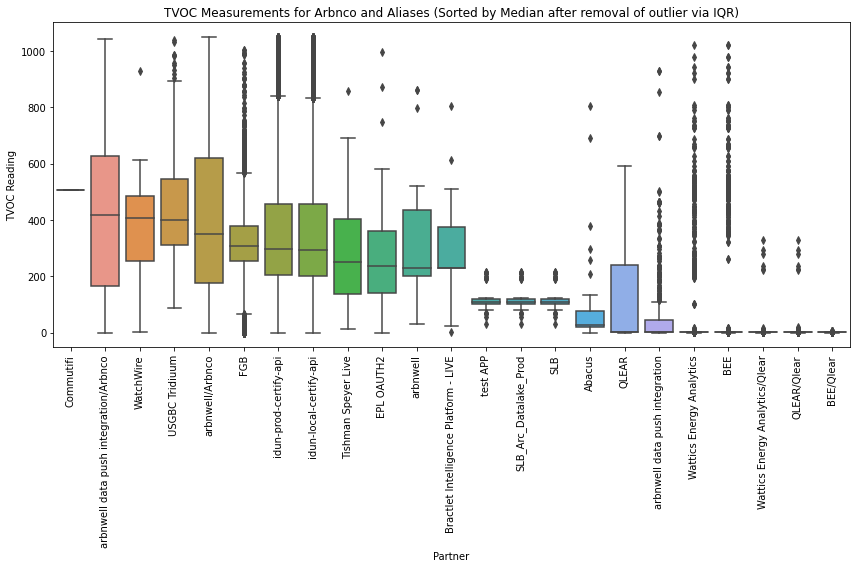

In [39]:
median_readings = df_iqr.groupby('partner')['reading'].median().sort_values(ascending=False)

partner_order = median_readings.index

plt.figure(figsize=(12, 8))
sns.boxplot(x='partner', y='reading', data=df_iqr, order=partner_order)
plt.xlabel('Partner')
plt.ylabel('TVOC Reading')
plt.title('TVOC Measurements for Arbnco and Aliases (Sorted by Median after removal of outlier via IQR)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


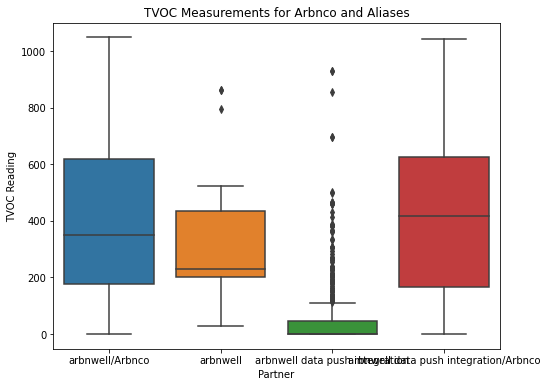

In [40]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='partner', y='reading', data=df_iqr[df_iqr['partner'].isin(arbnco_aliases)])
plt.xlabel('Partner')
plt.ylabel('TVOC Reading')
plt.title('TVOC Measurements for Arbnco and Aliases')
plt.show()